# Interactive QA with DB

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2


In [ ]:
# | hide
from stringdale.core import get_git_root, load_env, checkLogs, json_render

load_env()

import pytest

In [ ]:
from pathlib import Path
from pprint import pprint
from pydantic import BaseModel,Field,ConfigDict
from typing import Union,Literal,Optional
from sqlmodel import SQLModel, Session, select, Field

from stringdale.diagrams import (
    Define,Scope,
    V,E,
    draw_diagram
)
from stringdale.core import has_missing
from stringdale.chat import Chat
from stringdale.std import Condition as C
from stringdale.db import temp_sql_db


## Collect missing data from user

In this example we will create an agent the collects missing data from the user with the following imporvements:
* The user will check if we already have data for the user, if we do, they will confirm it is correct
* If the user takes too long to respond, the agent will save the current state with the missing data and continue later
* the agent will save the data to the db oncce we have all the data

In [ ]:
engine = temp_sql_db(echo=False)


In [ ]:
SQLModel.metadata.clear()

#  Define your model (if using SQLModel)
class User(SQLModel, table=True,extend_existing=True):
    id: int = Field(default=None, primary_key=True)
    name: Optional[str] = Field(default=None)
    age: Optional[int] = Field(default=None)
    email: Optional[str] = Field(default=None)

SQLModel.metadata.create_all(engine)

In [ ]:
ask_missing_data = Chat(
    model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant asks the user for missing information.
        The information we have so far is:
        {{current_info}}
        Ask the user for the missing information.
        '''}])

format_new_info = Chat(
    model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant that gets user data and makes sure it is complete.
        If you are not sure that you were given the relevant information, put None in the relevant field.
        {% if current_info %}
        The information we have so far is:
        {{current_info}}
        {% endif %}
        The user will supply the missing information.
        '''},
        {'role':'user','content':'{{input}}'},
    ],
    output_schema=User)

has_missing_data = C(has_missing,'(0=content)',name='has_missing_data')


In [ ]:
res = await format_new_info(input='my age is 20',current_info=User(id=1, name="Alice"))
res

{'role': 'assistant',
 'content': User(id=1, name='Alice', age=20, email=None),
 'meta': {'input_tokens': 327, 'output_tokens': 30}}

In [ ]:
# Define a Custom State Object


class UserDBState(BaseModel):
    model_config = ConfigDict(extra='allow')
    user_id:int
    _user:Optional[User]=None

    @property
    def engine(self):
        return temp_sql_db(echo=False)

    def get_user(self):
        user_id = self.user_id
        if not self._user is None:
            return self._user
        with Session(self.engine) as session:
            user = session.exec(select(User).where(User.id == user_id)).first()
            self._user = user
            return user

    def add_user(self,user_data):
        self._user = user_data
        with Session(self.engine) as session:
            session.merge(user_data)
            session.commit()
        

In [ ]:
state = UserDBState(user_id=1)
print(state.get_user())
state.add_user(User(id=1,name='Alice',age=30,email='alice@example.com'))
print(state.get_user())


None
id=1 name='Alice' age=30 email='alice@example.com'


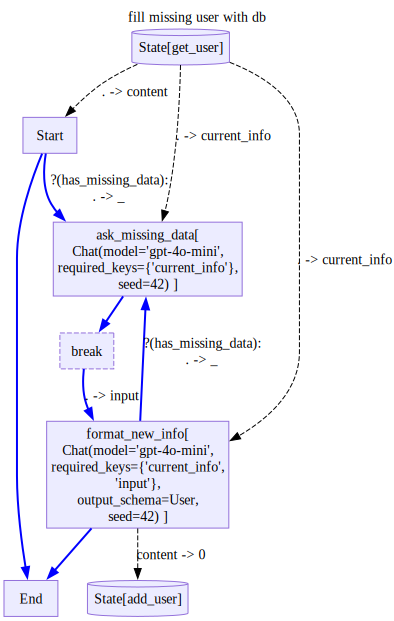

In [ ]:
with Define('fill missing user with db',type='decision',state=UserDBState) as D:
    
    V('Start',inputs=['state/get_user(content)'],
        outputs=[
            ('ask_missing_data(_)',has_missing_data),
            'End',
            ]
        )

    V('ask_missing_data',ask_missing_data,
        inputs=['state/get_user(current_info)'],
        outputs=['break']
    )

    V('break',is_break=True,outputs=['format_new_info(input)'])

    
    V('format_new_info',format_new_info,
        inputs=['state/get_user(current_info)'],
        outputs=[
            ('ask_missing_data(_)',has_missing_data),
            'End',
            'state/add_user(0=content)'
        ])


In [ ]:
d = D()
# with checkLogs(name='stringdale.diagrams'):
for trace in d.run(input=None,state={'user_id':1,'db_string':'Memory'}):
    trace.pprint()

d.output

Node Start:
{ 'input': { 0: None,
             'content': User(age=30, id=1, name='Alice', email='alice@example.com')},
  'output': { 0: None,
              'content': User(age=30, id=1, name='Alice', email='alice@example.com')}}
Node End:
{ 'input': { 0: { 0: None,
                  'content': User(age=30, id=1, name='Alice', email='alice@example.com')}},
  'output': { 0: None,
              'content': User(age=30, id=1, name='Alice', email='alice@example.com')}}


{0: None,
 'content': User(age=30, id=1, name='Alice', email='alice@example.com')}

In [ ]:
d.state

UserDBState(user_id=1, db_string='Memory')

In [ ]:
d.state.get_user()

User(age=30, id=1, name='Alice', email='alice@example.com')